In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [7]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [48]:
# Find the most recent date in the data set.
## I used chatgpt to fix from a tuple to a string by adding [0]
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
print(most_recent_date)

2017-08-23


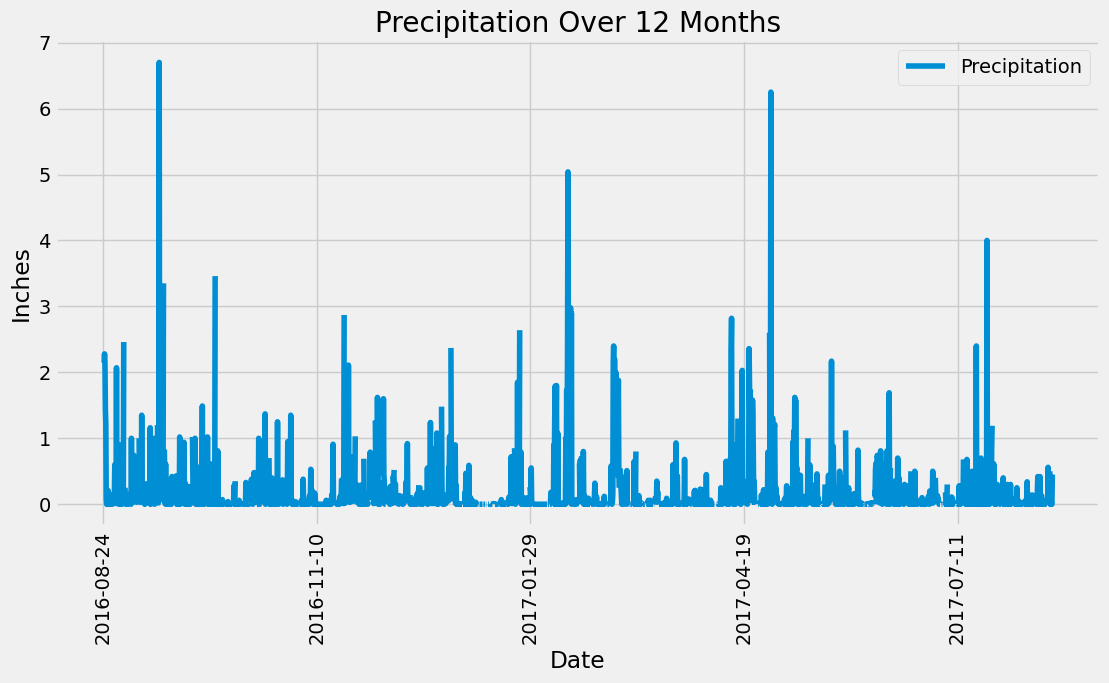

In [121]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.date, measurement.prcp).\
    filter(func.strftime(measurement.date) >= query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precip_df = precip_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(x='Date', y='Precipitation', figsize=(12,6))
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.title('Precipitation Over 12 Months')
plt.show()


In [55]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [61]:
inspector = inspect(engine)

columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [72]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.id)).scalar()

9

In [87]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station))\
                 .group_by(measurement.station)\
                 .order_by(func.count(measurement.station).desc())\
                 .all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [89]:
most_active_station_id = active_stations[0][0]
print(most_active_station_id)


USC00519281


In [120]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(measurement.station == most_active_station_id).all()
temp_stats

# Extract the values
lowest_temp, highest_temp, avg_temp = temps[0]

# Print the results
print(f"Station {most_active_station_id}:")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp:.2f}")

Station USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


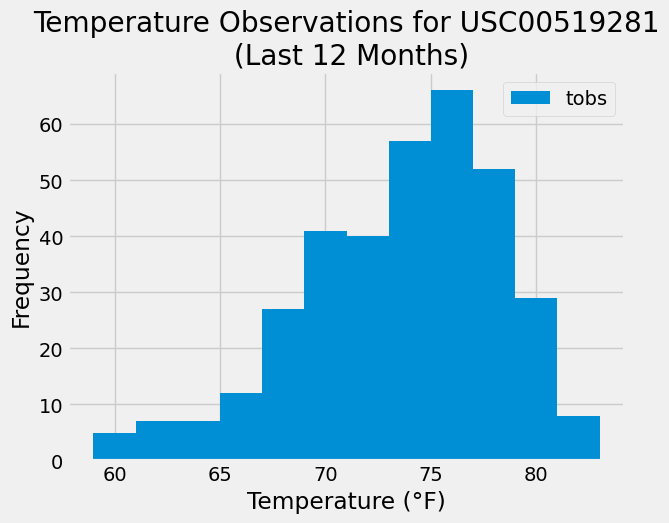

In [118]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_query = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station_id).\
    filter(func.strftime(measurement.date) >= query_date).all()

station_temp_df = pd.DataFrame(temp_query, columns=['Temperature'])


plt.hist(station_temp_df['Temperature'], bins=12, label='tobs')
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observations for {most_active_station_id}\n (Last 12 Months)")
plt.legend()
plt.show()

# Close Session

In [109]:
# Close Session
session.close()